In [1]:
import tensorflow as tf
import os
import zipfile
import random
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Rescaling

In [ ]:
zip_file_path = '/content/Teeth DataSet.zip'

extract_dir = '/content/your_extracted_folder'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
train_dir="/content/your_extracted_folder/Teeth_Dataset/Training"
val_dir="/content/your_extracted_folder/Teeth_Dataset/Validation"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    label_mode='categorical',
    image_size=(256,256)
)

Found 3087 files belonging to 7 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    label_mode='categorical',
    image_size=(256,256)
)

Found 1028 files belonging to 7 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


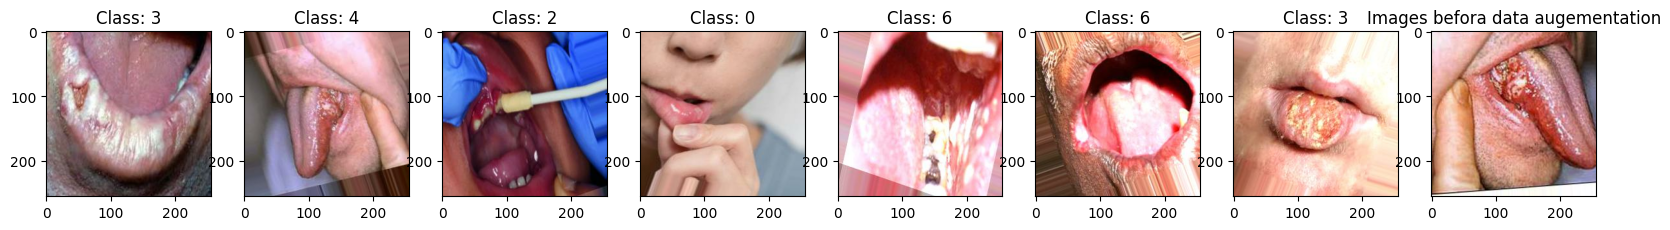

In [ ]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()

images = batch[0]
labels = batch[1]

label_indices = np.argmax(labels, axis=-1)

fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
for idx, img in enumerate(images[:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f'Class: {label_indices[idx]}')

plt.title('Images befora data augementation')
plt.show()

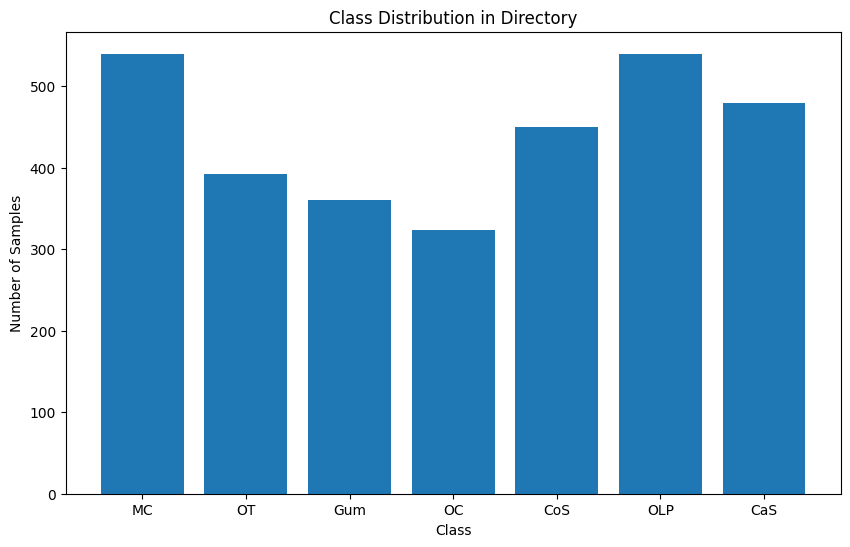

In [ ]:
data_dir = '/content/your_extracted_folder/Teeth_Dataset/Training'

class_counts = {}

for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    num_files = len(os.listdir(class_path))
    class_counts[class_dir] = num_files

class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Directory')
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 7)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

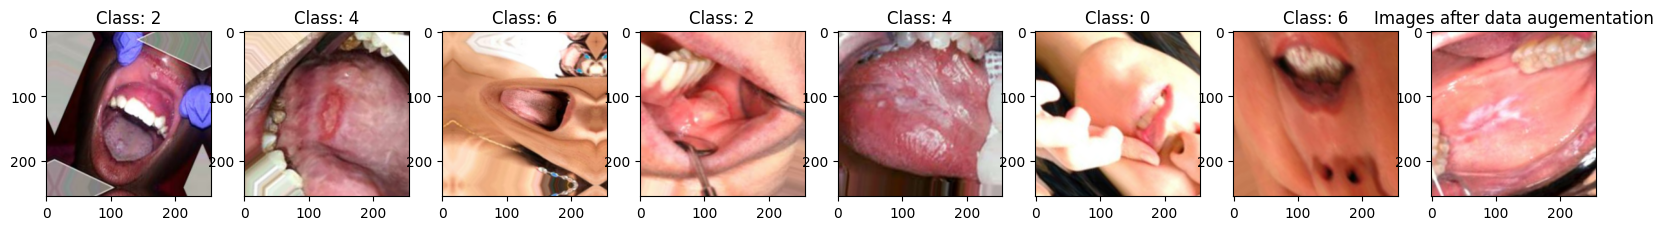

In [ ]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()

images = batch[0]
labels = batch[1]

label_indices = np.argmax(labels, axis=-1)

fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
for idx, img in enumerate(images[:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f'Class: {label_indices[idx]}')

plt.title('Images after data augementation')
plt.show()

In [ ]:
normalization_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()

images = batch[0]
images.min(), images.max()

(0.0, 1.0)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
inputs = layers.Input(shape=(256, 256, 3))

# Initial Conv Layer
x = layers.Conv2D(16, kernel_size=7, strides=2, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.005))(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Block 1
shortcut = x
x = layers.Conv2D(8, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.BatchNormalization()(x)
x = layers.add([x, shortcut])
x = layers.ReLU()(x)


# Block 3
shortcut = layers.Conv2D(32, kernel_size=1, strides=2, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.BatchNormalization()(x)
x = layers.add([x, shortcut])
x = layers.ReLU()(x)

# Block 4
shortcut = layers.Conv2D(64, kernel_size=1, strides=2, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.Conv2D(20, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.05))(x)
x = layers.BatchNormalization()(x)
x = layers.add([x, shortcut])
x = layers.ReLU()(x)

# Global Average Pooling and Dense Layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True)

In [ ]:
model_filepath = "/content/model-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 128, 128, 16)   │          2,352 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 128, 128, 16)   │             64 │ conv2d_93[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_72 (ReLU)           │ (None, 128, 128, 16)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 64, 64, 16)     │              0 │ re_lu_72[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 64, 64, 8)      │          1,152 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 64, 64, 8)      │             32 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_73 (ReLU)           │ (None, 64, 64, 8)      │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 64, 64, 16)     │          1,152 │ re_lu_73[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 64, 64, 16)     │             64 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 64, 64, 16)     │              0 │ batch_normalization_7… │
│                           │                        │                │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_74 (ReLU)           │ (None, 64, 64, 16)     │              0 │ add_31[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 32, 32, 16)     │          2,304 │ re_lu_74[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_76    │ (None, 32, 32, 16)     │             64 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_75 (ReLU)           │ (None, 32, 32, 16)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 32, 32, 32)     │          4,608 │ re_lu_75[0][0]         │
├──────────────────────

 Total params: 36,711 (143.40 KB)

 Trainable params: 36,367 (142.06 KB)

 Non-trainable params: 344 (1.34 KB)

In [ ]:
hist = model.fit(train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=[early_stopping,checkpoint, reduce_lr],
)

Epoch 1/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1974 - loss: 2.9558
Epoch 1: val_accuracy improved from -inf to 0.14494, saving model to /content/model-01-0.1449.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.1978 - loss: 2.9547 - val_accuracy: 0.1449 - val_loss: 2.9419 - learning_rate: 3.0000e-04
Epoch 2/150
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3205 - loss: 2.6145
Epoch 2: val_accuracy did not improve from 0.14494
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3207 - loss: 2.6138 - val_accuracy: 0.1449 - val_loss: 3.5892 - learning_rate: 3.0000e-04
Epoch 3/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3544 - loss: 2.4777
Epoch 3: val_accuracy did not improve from 0.14494
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3544 - loss: 2.4774 - val_accuracy: 0.1449 - val_loss: 3.9706 - learning_rate: 3.0000e-04
Epoch 4/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3697 - loss: 2.3546
Epoch 4: val_accurac

In [ ]:
new_model=load_model("/content/modell-60-0.6342.keras")


In [ ]:
new_model.compile(optimizer=Adam(learning_rate=(3e-4)/16), loss='categorical_crossentropy', metrics=['accuracy'])
hist = new_model.fit(train_ds,
    validation_data=val_ds,
    initial_epoch=len(hist.history['loss']),
    epochs=100,
    callbacks=[early_stopping,checkpoint, reduce_lr],
)

KeyError: 'loss'

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/your_extracted_folder/Teeth_Dataset/Training",
    shuffle=False,
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

In [ ]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
my_model.evaluate(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 691ms/step - accuracy: 0.6314 - loss: 1.2631


[1.2161058187484741, 0.6439688801765442]